# Decision analysis with a utility function

:::{post} Dec 15, 2022
:tags: Bayesian workflow, decision analysis
:category: beginner, how-to
:author: Oriol Abril Pla
:::

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm

from scipy import stats
from xarray_einstats.stats import XrContinuousRV, XrDiscreteRV

In [2]:
RANDOM_SEED = 4235
rng = np.random.default_rng(RANDOM_SEED)

## Overview

In this example we will show how to perform Bayesian decison analysis over a set of discrete decisions. We will use as an example, we will take the role of a shopper, who has done their weekly grocery shopping at a different supermarket every week for the last year, and has logged:

* The supermarket they went to that week
* The cumulative time it took from exiting home to getting back, so both travel time and unintuitive supermarket layout are penalized (in hours)
* The money spent (in euros)
* The number of rubbish bins that were filled that week

## Example data

In [3]:
obs_supermarket = rng.choice(["aldi", "caprabo", "condis", "consum", "keisy"], size=52)
super_id, supermarkets = pd.factorize(obs_supermarket, sort=True)
time_means = np.array([7, 5, 4.7, 6, 5.2])
cost_means = np.array([90, 125, 130, 120, 150])
rubbish_means = np.array([5, 3, 4, 4, 3])
obs_time = rng.normal(time_means[super_id], 0.2)
obs_cost = rng.normal(cost_means[super_id], 1)
obs_rubbish = rng.poisson(rubbish_means[super_id])

## Model definition

In [4]:
coords = {
    "supermarket": supermarkets,
    "measure": ["time", "cost"],
}
with pm.Model(coords=coords) as model:
    model.add_coord("week", length=len(super_id), mutable=True)
    supermarket_id = pm.MutableData("supermarket_id", super_id, dims="week")

    mu = pm.Normal("mu", 0, 1, dims=("measure", "supermarket"))
    sigma = pm.HalfNormal("sigma", 0.5, dims=("measure", "supermarket"))
    lam = pm.Exponential("lam", 0.3, dims="supermarket")

    pm.Normal(
        "time",
        mu=mu[0, supermarket_id],
        sigma=sigma[0, supermarket_id],
        dims="week",
        observed=obs_time,
    )
    pm.Normal(
        "cost",
        mu=mu[1, supermarket_id],
        sigma=sigma[1, supermarket_id],
        dims="week",
        observed=obs_cost,
    )
    pm.Poisson("rubbish", mu=lam[supermarket_id], dims="week", observed=obs_rubbish)

## Inference

In [5]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, lam]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [6]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

## Posterior predictive sampling

In [7]:
with model:
    model.set_dim("week", len(supermarkets))
    model.set_data("supermarket_id", np.arange(len(supermarkets)))

    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

# we can't rename dimensions in pymc, so we do it now
post_pred = idata.posterior_predictive
post_pred = post_pred.rename(week="supermarket").assign_coords(
    supermarket=idata.posterior["supermarket"]
)

Sampling: [cost, rubbish, time]


## Decision analysis

In [8]:
def utility(time, cost, rubbish):
    return -(cost + 20 * time + 2 * (rubbish + 1) ** 2)

In [9]:
util = utility(post_pred["time"], post_pred["cost"], post_pred["rubbish"])
util.mean(dim=("chain", "draw"))

<xarray.DataArray (supermarket: 5)>
array([-246.72746742, -145.02445363, -162.09484257, -180.34604534,
       -157.80864075])
Coordinates:
  * supermarket  (supermarket) <U7 'aldi' 'caprabo' 'condis' 'consum' 'keisy'

In [10]:
def utility_no_rubbish(time, cost, rubbish):
    return -(cost + 30 * time)


util2 = utility_no_rubbish(post_pred["time"], post_pred["cost"], post_pred["rubbish"])

Text(0.5, 1.0, 'Utility function **without** rubbish term')

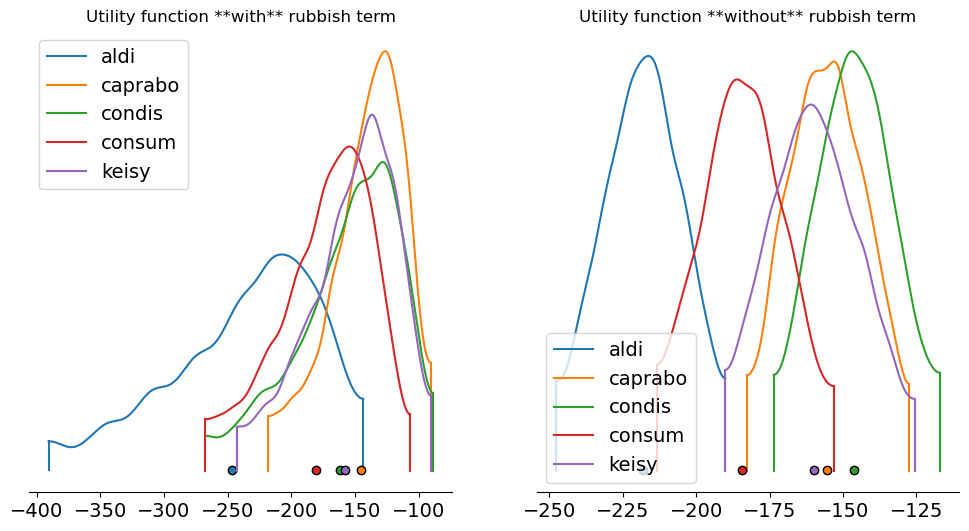

In [11]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 2, figsize=(12, 6))
az.plot_density(
    [util.sel(supermarket=s) for s in supermarkets],
    data_labels=supermarkets,
    labeller=az.labels.NoVarLabeller(),
    ax=ax[0],
)
ax[0].set_title("Utility function **with** rubbish term")
az.plot_density(
    [util2.sel(supermarket=s) for s in supermarkets],
    data_labels=supermarkets,
    labeller=az.labels.NoVarLabeller(),
    ax=ax[1],
)
ax[1].set_title("Utility function **without** rubbish term")

## Authors
* Authored by Oriol Abril Pla in Dec 2022

## References

:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray

Last updated: Thu Dec 15 2022

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.7.0

pytensor: 2.8.10
xarray  : 2022.12.0

arviz     : 0.14.0
scipy     : 1.9.3
matplotlib: 3.6.2
pandas    : 1.5.2
pymc      : 5.0.0
numpy     : 1.23.5

Watermark: 2.3.1



:::{include} ../page_footer.md
:::